# Github Push Event Forecasts

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.models as models
import deep4cast.custom_metrics as metrics
import deep4cast.utils as utils
import deep4cast.cv as cv

%matplotlib inline

Using TensorFlow backend.


## Data preparation

In [2]:
# # For our forecaster, we are going to have a lookback window called 'lag' and a horizon window
# # called 'horizon' for which we will forecast.
# horizon = 90 # measured in hours
# lag = 2*horizon  # measured in hours

# # Loading the dataset and dropping unncecessary columns
# df = pd.read_pickle('../data/processed/github_total_push_events_2011-2018.pkl')
# data = df.drop(['month', 'day'], axis=1)
# data = data.dropna()

# # We have real-valued and categorial features and we need to make sure that we do the data 
# # preparation for them correctly
# real_values = ['date', 'count', 'age']
# categorical = list(set(data.columns).difference(set(real_values)))
# #data = data.drop(categorical, axis=1)

# # Let's create lagged real features to include information about past seasonal behavior
# lagged = data[real_values].shift(365-horizon)
# lagged = lagged.rename(columns={column:column + '_lagged' for column in lagged.columns})
# data = pd.concat([data[real_values], lagged, data[categorical]], axis=1)
# data = data.dropna()
# data = data.reset_index(drop=True)

# # Training & testing boundary
# test_ind = data.index.where(data['date'] == dt.datetime(2017,6,4)).dropna().astype('int').values[0]

# # CF indices
# cf_ind = data.index.where(data['date'] == dt.datetime(2018,6,4)).dropna().astype('int').values[0]

# # Drop date columns
# data = data.drop(['date'], axis=1)
# data = data.drop(['date_lagged'], axis=1)

# # Format data into numpy array
# data = np.expand_dims(data.values, 0)

# # Now we need to sequentialize the training and testing dataset
# X_train, y_train = utils.sequentialize(data[:,:test_ind,:], lag, horizon, targets=[0])
# X_test, y_test = utils.sequentialize(data[:,test_ind-lag:cf_ind,:], lag, horizon, targets=[0])
# X_cf, y_cf = utils.sequentialize(data[:,cf_ind-lag:,:], lag, horizon, targets=[0])

# # Rescale the datasets so that the neural networks can be fitted properly and stably
# scaler = cv.VectorScaler(targets=[0, 1, 2, 3])
# scaler.fit_x(X_train)
# scaler.fit_y(y_train)
# X_train = scaler.transform_x(X_train)
# y_train = scaler.transform_y(y_train)
# X_test = scaler.transform_x(X_test)

In [3]:
# For our forecaster, we are going to have a lookback window called 'lag' and a horizon window
# called 'horizon' for which we will forecast.
horizon = 90 # measured in hours
lag = 2*horizon  # measured in hours

# Loading the dataset and dropping unncecessary columns
df = pd.read_pickle('../data/processed/github_total_push_events_2011-2018.pkl')
data = df.drop(['month', 'day', 'age'], axis=1)
data = data.dropna()
data['count'] = np.log1p(data['count'])

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['count']
categorical = list(set(data.columns).difference(set(real_values)))

# Let's create lagged real features to include information about past seasonal behavior
lagged = data[real_values].shift(365-horizon)
lagged = lagged.rename(columns={column:column + '_lagged' for column in lagged.columns})
data = pd.concat([data, lagged], axis=1)
data = data.dropna()
data = data.reset_index(drop=True)

# Training & testing boundary
test_ind = data.index.where(data['date'] == dt.datetime(2017,6,4)).dropna().astype('int').values[0]

# CF indices
cf_ind = data.index.where(data['date'] == dt.datetime(2018,6,4)).dropna().astype('int').values[0]

# Drop date columns
data = data.drop(['date'], axis=1)

# Format data into numpy array
data = np.expand_dims(data.values, 0)

# Now we need to sequentialize the training and testing dataset
X_train, y_train = utils.sequentialize(data[:,:test_ind,:], lag, horizon, targets=[0])
X_test, y_test = utils.sequentialize(data[:,test_ind-lag:cf_ind,:], lag, horizon, targets=[0])

# Rescale the datasets so that the neural networks can be fitted properly and stably
scaler = cv.VectorScaler(targets=[0, -1])
scaler.fit_x(X_train)
scaler.fit_y(y_train)
X_train = scaler.transform_x(X_train)
y_train = scaler.transform_y(y_train)
X_test = scaler.transform_x(X_test)
y_test = np.expm1(y_test)

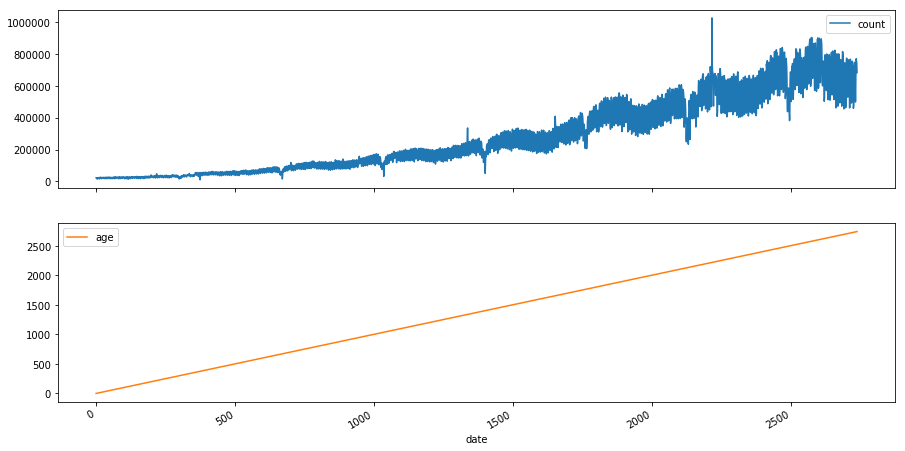

In [4]:
# Let plot the data
df[['count', 'age']].plot(subplots=True, figsize=(15, 8))
plt.xlabel('date')

plt.show()

# Modeling

In [5]:
model = models.WaveNet(filters=64, num_layers=2)

In [6]:
forecaster = Forecaster(
    model,
    lag=lag,  # This is the number of time steps used to predict the future for each data point
    horizon=horizon,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    epochs=40
)

In [7]:
forecaster.fit(X_train, y_train, verbose=1)

Epoch 1/40
1741/1741 [==============================] - 8s 4ms/step - loss: 0.1493
Epoch 2/40
1741/1741 [==============================] - 2s 1ms/step - loss: -0.6367
Epoch 3/40
1741/1741 [==============================] - 2s 1ms/step - loss: -1.0409
Epoch 4/40
1741/1741 [==============================] - 2s 1ms/step - loss: -1.3064
Epoch 5/40
1741/1741 [==============================] - 2s 1ms/step - loss: -1.6101
Epoch 6/40
1741/1741 [==============================] - 2s 1ms/step - loss: -1.7028
Epoch 7/40
1741/1741 [==============================] - 2s 1ms/step - loss: -1.8929
Epoch 8/40
1741/1741 [==============================] - 2s 1ms/step - loss: -1.9631
Epoch 9/40
1741/1741 [==============================] - 2s 1ms/step - loss: -2.1736
Epoch 10/40
1741/1741 [==============================] - 2s 1ms/step - loss: -2.2225
Epoch 11/40
1741/1741 [==============================] - 2s 1ms/step - loss: -2.3455
Epoch 12/40
1741/1741 [==============================] - 2s 1ms/step - loss

Text(0,0.5,"['Loss']")

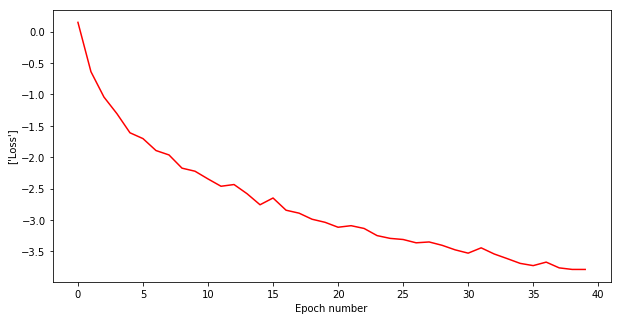

In [8]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.xlabel('Epoch number')
plt.ylabel(['Loss'])

# Evaluation

In [9]:
samples = []
n_samples=1000
for X_window in X_test[::horizon,:,:]:
    samples.append(forecaster.predict(np.expand_dims(X_window, axis=0), n_samples=n_samples))
samples = np.concatenate(samples, axis=1)
samples = scaler.inverse_transform_y(samples)
samples = np.expm1(samples)
prediction_mean = np.mean(samples, axis=0)
prediction_lq = np.percentile(samples, q=5, axis=0)
prediction_uq = np.percentile(samples, q=95, axis=0)

SMAPE: 15.58%
Pinball Score: 1983351.54
Coverage: 


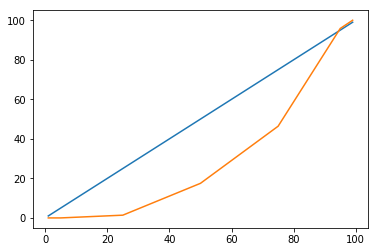

In [10]:
smape = metrics.smape(prediction_mean, y_test[::horizon,:,:])
cov, perc = metrics.coverage(samples, y_test[::horizon,:,:])
pinball = metrics.pinball_loss(samples, y_test[::horizon,:,:])

print('SMAPE: {}%'.format(smape))
print('Pinball Score: {}'.format(pinball))
print('Coverage: ')
plt.plot(perc, perc)
plt.plot(perc, cov)

Lastly, we can check how our predictions compare with the data.

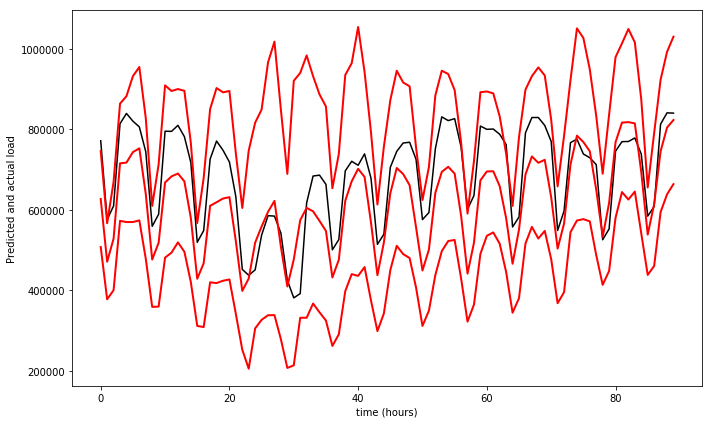

In [11]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(10, 6))
plt.plot(y_test[180,:,:], 'k')
plt.plot(prediction_mean[2,:,:], 'r', linewidth=2)
plt.plot(prediction_lq[2,:,:], 'r', linewidth=2)
plt.plot(prediction_uq[2,:,:], 'r', linewidth=2)
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()